# Tom and Jerry Dynamics

In this notebook, we study the impact of a velocity drift term on the diffusion of individual algal as induced by both collision and velocity affects of momentum transfer to the algae. This ends up generating a system where the bacteria chase oxygen which causes the expulsion of algae which produce oxygen so overall we get a bit of a chase! Whether this will hold up to experiments is yet to be seen but it's exciting to explore.

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt 

In [2]:
import scienceplots
plt.style.use(['science','no-latex'])

In [3]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, TransientTerm, DiffusionTerm, UpwindConvectionTerm, \
ImplicitSourceTerm,ExplicitDiffusionTerm

from fipy.tools import numerix

To review the model we are assuming that the oxygen dynamics are purely controlled by diffusion and consumption/production kinetics:

$$
\dfrac{\partial c}{\partial t} = D_c \nabla^2 c + k^+ a - k(c)^- b
$$

The oxygen consumption kinetics in this regime are given by Michealis Menton kinetics:

$$
k^-(c) = \dfrac{k^-  c}{ K_c + c}
$$

For now we'll just use the approximation that oxygen consumption is unsaturated so this becomes the form:

$$
\dfrac{\partial c}{\partial t} = D_c \nabla^2 c + k^+ a - k^- b c
$$

For bacteria, we model this using standard Keller Segel dynamics:

$$
\dfrac{ \partial b}{\partial t} = D_b \nabla^2 b + \nabla( \chi b \nabla c)
$$

For the algae, we need to be a bit careful. We made the fundamental assumption that the diffusion rate of algae is dictated by the relative concentration of the individual bacteria, which we assume (as implied by experimental evidence) is given by a linear relationship:

$$
D(x) = \beta b(x)
$$

Where $\beta$ is a phenomenological constant. From this we need to generalize Fick's law as:

$$
J(x) = -\nabla( D(x) b(x) )
$$

Which holds in the regime that the velocity and collision rates are both affected by the bacterial concentration. This gives us a formulation:

$$
\dfrac{\partial a}{\partial t} = \nabla \left( \, \nabla( D(x) b(x) \,) \right)
$$

Which when expanded gives a Keller-Segel form:

$$
\dfrac{\partial a}{\partial t} = (\beta b) \nabla^2 \, a(x) + \beta \nabla( a \nabla b )
$$

More generally due to volume exclusion among other effects we anticipate: 

$$
\dfrac{\partial a}{\partial t} = (\beta b) \nabla^2 \, a(x) + \gamma \nabla( a \nabla b )
$$



We will begin our simulation by defining initial conditions and a grid for numerics, leveraging simple finite volume method provided by FiPy. 

In [4]:
# Number of cells
L = 1
nx = 100

# Length of domain unit
dx = L/nx

# Construct mesh. 
m = Grid1D(nx=nx, dx=dx)


# Define the time step
T = 10
D = 1

# Compute the time step duration using the CFL criterion, also compute the CFL criterion to get a sense of scale for the system. 
timeStepDuration = 0.01
steps = int(T/timeStepDuration)

print("SIMULATION PARAMETERS:")
print("dx size: ", dx)
print("Diffusion CFL:", dx**2 / (2 * D))
print("Time step:", timeStepDuration)
print("Integration Time:", timeStepDuration*steps)
print("Number Iterations:", steps)

SIMULATION PARAMETERS:
dx size:  0.01
Diffusion CFL: 5e-05
Time step: 0.01
Integration Time: 10.0
Number Iterations: 1000


Let's now define the initial conditions for the system, we will for now assume the system is homogeneously illuminated everywhere and the system starts with a homogeneous bacteria concentration with a single spot of algae in the center of the system. *Note there is **no** spatially heterogeneous light distribution.*

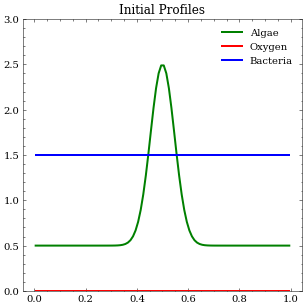

In [5]:
c = CellVariable(name="oxygen",mesh=m,value= 0.0)
a = CellVariable(name ="algae", mesh = m, value = 1.0)
b = CellVariable(name = "bacteria", mesh = m, value = 1.5)


# Generate an initial Gaussian profile for the algae. 
wf = 5

mu = L/2
sigma = L/15
mask = 2.0*np.exp(-(m.x-mu)**2/sigma**2)
a[(m.x > L/2 - L/(2*wf)) & (m.x < L/2 + L/(2*wf))] = 1.0
a.setValue(mask + 0.5) #mask + 0.05*np.random.randn(nx) + 0.2
    
# Plot the initial profiles 

plt.figure(figsize = (5,5))
plt.title("Initial Profiles")
plt.ylim(0,3.0)
plt.plot(m.x.value, np.array(a), color = "green", label = "Algae", lw = 2)
plt.plot(m.x.value, np.array(c), color = "red", label = "Oxygen" , lw = 2)
plt.plot(m.x.value, np.array(b), color = "blue", label = "Bacteria" , lw =2 )
plt.legend()
plt.show()

### Defining Equations

We will now set the equations for our system, fixing parameters here just for convenience. 

$$
\begin{aligned}
& \frac{\partial c}{\partial t}=D_c \nabla^2 c+k^{+}(\phi) a-k^{-} b c \\
& \frac{\partial b}{\partial t}=D_b \nabla^2 b-r \nabla(b \nabla c) \\
& \frac{\partial a}{\partial t}=(\beta b) \nabla^2 a+\gamma \nabla(a \nabla b)
\end{aligned}
$$

Estimating $\beta$ from experimental data will be challenging, but here we'll just assume when $b = 1$, the diffusion constant will be $D_a = \beta(1) = 0.1$. We can rescale this as needed based on experiments. 

In [6]:
# Define the diffusion constants
D_c = 1
D_b = 0.1 
beta = 0.1 

# Define the kinetic parameters
k_plus = 1.0
k_minus = 0.01

# Define the advective parameters
r = 2.0
gamma = 2.0

Now define the actual equations:

In [7]:
# Oxygen term
eqX = TransientTerm(var = c) == DiffusionTerm(coeff= D_c, var = c) + ImplicitSourceTerm(var = a, coeff = k_plus) \
    - ImplicitSourceTerm(coeff = k_minus*c, var = b)

# Bacteria term
taxis_coeff = r*c.grad
eqZ = TransientTerm(var = b) == DiffusionTerm(coeff = D_b, var = b)  - UpwindConvectionTerm(coeff=taxis_coeff, var = b)

# Algae term
D_ani = beta*b
dispersal_coeff = gamma*b.grad
eqY = TransientTerm(var = a) == DiffusionTerm(coeff = D_ani, var = a) + UpwindConvectionTerm(coeff = dispersal_coeff, var = a)

# Combine into a single equation
eqN = eqX & eqY & eqZ

We now simulate our system:

In [8]:
from tqdm import trange, tqdm

from builtins import range

# Create arrays to store the transients dynamics for algae, bacteria, and oxygen. 
a_tt = []
b_tt = []
c_tt = []

t = 0.0
for step in trange((steps)):
    t += timeStepDuration
    t = np.around(t,1)
    eqN.solve(dt=timeStepDuration)
    
    # Save the simulation values only every 10 time steps. 
    if t % 10.0 == 0.0:
        a_tt.append(a.value.copy())
        b_tt.append(b.value.copy())
        c_tt.append(c.value.copy())

100%|██████████| 1000/1000 [00:26<00:00, 37.59it/s]


### Plotting the Simulation

We analyze the results by plotting a video of the solution. The code below just carefully generates a lot of subplots visualizing different aspects of the system dynamics and plots them all in one large video, the specifics of how it worse are both uninteresting and verbose: 

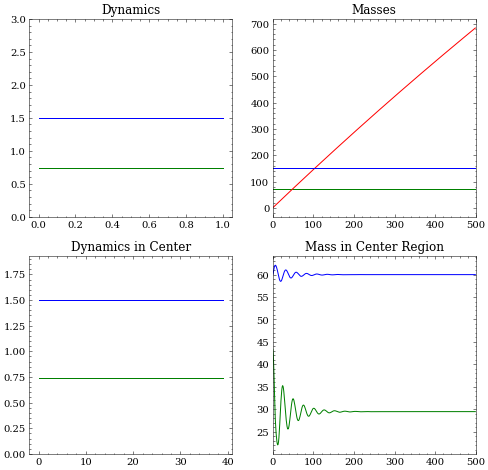

In [10]:
a_tt = np.array(a_tt)
c_tt = np.array(c_tt)
b_tt = np.array(b_tt)

from IPython.display import clear_output
from celluloid import Camera

# Toggle from true to false if we wish to save a gif of the final resutls, otherwise the simulation results will be played
# in real time.
save_gif = False

if save_gif:
    fig, [[ax1,ax2], [ax3,ax4]]= plt.subplots(2,2, figsize = (8, 8))
    camera = Camera(fig)

step =2
end = a_tt.shape[0]

a_masses = []
b_masses = []
c_masses = []

algae_region = []
bacteria_region = []
oxygen_region = []

for i in np.arange(start = 0, stop = end, step= step):
    
    x_mesh = np.linspace(0,L,nx)
    if not save_gif:
        fig, [[ax1,ax2], [ax3,ax4]]= plt.subplots(2,2, figsize = (8, 8))
        
    #ax1.set_ylim(0,min( max(a_tt.max(),b_tt.max(),),100 ))#c_tt.max())) 
    ax1.set_ylim(0,3.0)
    ax1.plot(x_mesh, a_tt[i], color = "green")
    ax1.plot(x_mesh, c_tt[i], color = "red")
    ax1.plot(x_mesh, b_tt[i], color = "blue")
    #ax1.plot(x_mesh, np.array(phi), color = "gold")
    ax1.set_title("Dynamics")
    
    region = (m.x > L/2 - L/wf ) & (m.x <L/2 + L/wf )
    a_tt_sel = a_tt[i][ region ]
    b_tt_sel = b_tt[i][ region ]
    c_tt_sel = c_tt[i][ region ]
    
    ax3.set_ylim(0,max(a_tt.max(),b_tt.max(),))#c_tt.max())) 
    ax3.plot(a_tt_sel, color = "green")
    ax3.plot(c_tt_sel, color = "red")
    ax3.plot(b_tt_sel, color = "blue")
    ax3.set_title("Dynamics in Center")
    
    #ax1.fill_betweenx( np.linspace(0,11+1,100), L/2 - L/wf, L/2 + L/wf, facecolor='yellow', alpha=0.5, )
    
    region_mass = np.sum(a_tt_sel)
    b_region_mass = np.sum(b_tt_sel)
    c_region_mass = np.sum(c_tt_sel)
    
    algae_region.append(region_mass)
    bacteria_region.append(b_region_mass)
    oxygen_region.append(c_region_mass)
        
    a_masses.append(np.sum(a_tt[i]))
    c_masses.append(np.sum(c_tt[i]))
    b_masses.append(np.sum(b_tt[i]))
    
    # ax2.set_ylim(0,c_tt.max())
    ax2.set_xlim(0,end/step)
    ax2.plot( a_masses, color = "green")
    ax2.plot( c_masses, color = "red")
    ax2.plot( b_masses, color = "blue")
    ax2.set_title("Masses")
    
    ax4.set_xlim(0,end/step)
    #ax4.set_ylim(0,max(oxygen_region)+10)
    ax4.plot(algae_region, color = "green")
    ax4.plot(bacteria_region, color = "blue")
    #ax4.plot(oxygen_region, color = "red")
    ax4.set_title("Mass in Center Region")

    plt.show()
    
    if save_gif:
        camera.snap()
    else:
        clear_output(wait = True)

In [ ]:
plt.figure(figsize = (10,4))
plt.title("Algae")
plt.imshow(a_tt, interpolation = "nearest", aspect = "auto", cmap = "Greens")
plt.show()

plt.figure(figsize = (10,4))
plt.title("Bacteria")
plt.imshow(b_tt, interpolation = "nearest", aspect = "auto", cmap = "Blues")
plt.show()

plt.figure(figsize = (10,4))
plt.title("Oxygen")
plt.imshow(c_tt, interpolation = "nearest", aspect = "auto",cmap = "Reds")
plt.show()

Run the below code to generate a video of the simulation: 

In [ ]:
# anim = camera.animate()

# from IPython.display import HTML
# animation = camera.animate()
# HTML(animation.to_html5_video())